In [1]:
!pip install varname

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os, cv2, shutil, random
import json
import warnings
warnings.simplefilter('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm
from skimage import io
from PIL import Image
from matplotlib import pyplot as plt
%matplotlib inline
from requests.compat import urlparse, urlunparse, urljoin
from bs4 import BeautifulSoup
import re
import requests
from requests import Session, request, get
import urllib.request
from urllib.request import urlopen
from urllib.error import URLError, HTTPError
from varname import nameof
from functools import reduce 
import sqlite3
import random

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import tensorflow as tf
from pathlib import Path

from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Dropout, Input
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import resnet, resnet_v2, ResNet50, ResNet50V2, EfficientNetB3, InceptionV3, InceptionResNetV2
from tensorboard.plugins import projector

In [6]:
def myPreprocess_image_fin(fname):
  try:
    image_string = tf.io.read_file(fname)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, (224,224,3)[:2]) # TARGET_SHAPE
    return image
  except:
    print(fname)

In [7]:
def visualize(anchor, positive, negative, n=3):
    """Visualize triplets from the supplied batches."""

    def show(ax, image):
        ax.imshow(image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig = plt.figure(figsize=(3*n, 9))

    axs = fig.subplots(n, 3)
    for i in range(n):
        show(axs[i, 0], anchor[i])
        show(axs[i, 1], positive[i])
        show(axs[i, 2], negative[i])

In [ ]:
def substitute(url):
    base_dir = r"/content/drive/Othercomputers/내 노트북 (2)/test_002013"
    for i in os.listdir(base_dir):
        if i == (url.split('/')[-2] + '_' + url.split('/')[-1][:-4] + '.' + url[-3:]):
            try:
                if tf.io.read_file(os.path.join(base_dir ,i)):
                    return os.path.join(base_dir ,i)
            except:
                return "0"
    return "0"

In [8]:
def create_negative(dataframe, idx): 

    rand_int = random.randint(0, len(dataframe)-1)
    if dataframe.loc[idx, "goods_id"] != dataframe.loc[rand_int, "goods_id"]:
        dataframe.loc[idx, "negative"] = dataframe.loc[rand_int, "positive"]
        
    else:
        create_negative(dataframe, idx)

Load Data

In [9]:
df_styleReview_merge = pd.read_csv("/content/drive/MyDrive/3rd_project/df_styleReview_merge_pure.csv", dtype=object)

In [10]:
sample_path_drive = []
sample_path_local = df_styleReview_merge.sample_path_local.to_list()
for i in sample_path_local:
  sample_path_drive_elm = "/content/drive/Othercomputers/내 노트북/12sw_project.v4i.tensorflow/sampleImg/" + i.split('\\')[-1]
  sample_path_drive.append(sample_path_drive_elm)

review_path_drive = []
for i, row in df_styleReview_merge.iterrows():
    base_dir = "/content/drive/Othercomputers/내 노트북/12sw_project.v4i.tensorflow/train"
    review_path_drive_elm = os.path.join(base_dir, row["filename"])
    review_path_drive.append(review_path_drive_elm)

df_styleReview_merge["sample_path_drive"] = sample_path_drive
df_styleReview_merge["review_path_drive"] = review_path_drive

In [11]:
df_styleReview_merge

,goods_id_pure,index,filename,width,height,xmin,ymin,xmax,ymax,goods_id,mid_category,goods_image,sample_path_local,review_path_local,sample_path_drive,review_path_drive
0,25868,2776,25868_0_gallery_5bc7100bc4ff6_jpg.rf.6447220e7...,298,717,0,0,298,717,25868,003002,https://image.msscdn.net/images/goods_img/2012...,C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...,C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...
1,25868,1168,25868_0_gallery_5bcc87a2b5ce9_jpg.rf.b6559a493...,368,809,0,0,368,809,25868,003002,https://image.msscdn.net/images/goods_img/2012...,C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...,C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...
2,25868,1281,25868_0_gallery_5e57d8c343ff9_jpg.rf.bc6e3cebc...,133,373,0,0,133,373,25868,003002,https://image.msscdn.net/images/goods_img/2012...,C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...,C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...
3,25868,3062,25868_0_gallery_5bff80bbdad6a_jpg.rf.7201fb298...,370,583,0,0,370,583,25868,003002,https://image.msscdn.net/images/goods_img/2012...,C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...,C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...
4,25868,1149,25868_0_gallery_5f51a6f94de0f_jpg.rf.b63152a86...,68,166,0,0,68,166,25868,003002,https://image.msscdn.net/images/goods_img/2012...,C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...,C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5084,2930893,563,2930893_0_gallery_6390a095e1d56_jpg.rf.1a1691c...,181,158,0,0,181,158,2930893,018002,https://image.msscdn.net/images/goods_img/2022...,C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...,C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...
5085,2946308,984,2946308_0_gallery_63870cdf9a6ca_jpg.rf.aed7fd1...,1252,1543,0,0,1252,1543,2946308,002021,https://image.msscdn.net/images/goods_img/2022...,C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...,C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...
5086,2946977,2536,2946977_0_gallery_638c3022598b8_jpg.rf.9983a27...,68,63,0,0,68,63,2946977,005011,https://image.msscdn.net/images/goods_img/2022...,C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...,C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...
5087,2946977,629,2946977_0_gallery_638f4eaec5812_jpg.rf.1da588c...,131,87,0,0,131,87,2946977,005011,https://image.msscdn.net/images/goods_img/2022...,C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...,C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...


In [12]:
df_styleReview_merge.to_csv("/content/drive/MyDrive/3rd_project/df_styleReview_merge_drive.csv", index=False)

001011

In [13]:
df_styleReview_merge_drive = pd.read_csv("/content/drive/MyDrive/3rd_project/df_styleReview_merge_drive.csv", dtype=object)

In [14]:
df_styleReview_001011 = df_styleReview_merge_drive.groupby("mid_category").get_group("001011") # <-- 코드 수정
df_styleReview_001011["anchor"] = df_styleReview_001011["sample_path_drive"]
df_styleReview_001011["positive"] = df_styleReview_001011["review_path_drive"]

In [15]:
df_styleReview_001011.reset_index(inplace=True)

In [16]:
sub_anchor = df_styleReview_001011["anchor"].to_list()
sub_positive = df_styleReview_001011["positive"].to_list()

In [17]:
print(df_styleReview_001011.loc[0,:]["sample_path_drive"])
print(df_styleReview_001011.loc[0,:]["sample_path_local"])
print(df_styleReview_001011.loc[0,:]["review_path_drive"])
print(df_styleReview_001011.loc[0,:]["review_path_local"])

/content/drive/Othercomputers/내 노트북/12sw_project.v4i.tensorflow/sampleImg/20140424_87864_87864_1_500.jpg
C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\12sw_project.v4i.tensorflow\sampleImg\20140424_87864_87864_1_500.jpg
/content/drive/Othercomputers/내 노트북/12sw_project.v4i.tensorflow/train/87864_0_gallery_638823f59bcf7_jpg.rf.2c36c38ab449a26658f71ddede36248d.jpg
C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\12sw_project.v4i.tensorflow\train\87864_0_gallery_638823f59bcf7_jpg.rf.2c36c38ab449a26658f71ddede36248d.jpg


In [18]:
anchor_tensor = list()
for i in sub_anchor:
    k = myPreprocess_image_fin(i)
    anchor_tensor.append(k)

positive_tensor = list()
for i in sub_positive:
    k = myPreprocess_image_fin(i)
    positive_tensor.append(k)
    

image_count = len(anchor_tensor)

In [19]:
for i in range(0, len(df_styleReview_001011)):
      
  create_negative(df_styleReview_001011, i)

In [20]:
sub_negative = df_styleReview_001011["negative"].to_list()
negative_tensor = list()
for i in sub_negative:
    k = myPreprocess_image_fin(i)
    negative_tensor.append(k)
    

In [21]:
df_styleReview_001011.to_csv("/content/drive/MyDrive/3rd_project/df_styleReview_001011.csv", index=False)
df_styleReview_001011 = pd.read_csv("/content/drive/MyDrive/3rd_project/df_styleReview_001011.csv", dtype=object)

Training

In [49]:
BATCH_SIZE = 64
LEARNING_RATE = 1e-4
TARGET_SHAPE = (224, 224, 3)
EMBEDDING_DIMENSION = 256
EPOCHS = 100

In [50]:
tf.keras.backend.clear_session()

base_model = ResNet50(weights="imagenet", input_shape=TARGET_SHAPE, include_top=False)

for layer in base_model.layers:
    layer.trainable = True

x = Flatten()(base_model.output)
x = Dense(512, activation="relu")(x)
x = BatchNormalization()(x)
x = Dense(256, activation="relu")(x)
x = BatchNormalization()(x)

output = Dense(EMBEDDING_DIMENSION, activation="linear")(x)

embedding = Model(base_model.input, output, name="Embedding")

In [51]:
class DistanceLayer(tf.keras.layers.Layer):
    """
    This layer is responsible for computing the distance between the anchor
    embedding and the positive embedding, and the anchor embedding and the
    negative embedding.
    """

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)

anchor_input = Input(name="anchor", shape=TARGET_SHAPE)
positive_input = Input(name="positive", shape=TARGET_SHAPE)
negative_input = Input(name="negative", shape=TARGET_SHAPE)

distances = DistanceLayer()(embedding(resnet.preprocess_input(anchor_input)), embedding(resnet.preprocess_input(positive_input)), embedding(resnet.preprocess_input(negative_input)))

siamese_network = Model(inputs=[anchor_input, positive_input, negative_input], outputs=distances)

In [52]:
class SiameseModel(Model):
    """The Siamese Network model with a custom training and testing loops.

    Computes the triplet loss using the three embeddings produced by the
    Siamese Network.

    The triplet loss is defined as:
       L(A, P, N) = max(‖f(A) - f(P)‖² - ‖f(A) - f(N)‖² + margin, 0)
    """

    def __init__(self, siamese_network, margin=0.5):
        super(SiameseModel, self).__init__()
        self.siamese_network = siamese_network
        self.margin = margin
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.siamese_network.trainable_weights))
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        ap_distance, an_distance = self.siamese_network(data)
        loss = ap_distance - an_distance
        loss = tf.maximum(loss + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        return [self.loss_tracker]

빼고 다시 ..

In [ ]:
# df_photoReview_001_selected_apn.drop([369, 2017, 4508, 5157, 6011, 6573, 6697, 6727, 6945, 8840,3189, 3271, \
#                                       3290, 3376, 3385, 3431, 3475, 3552, 3828, 3871, 3941],axis=0, inplace=True)

In [ ]:
# df_photoReview_001_selected_apn_001001 = df_photoReview_001_selected_apn.groupby("mid_category").get_group("001001")

In [ ]:
# sub_anchor = df_photoReview_001_selected_apn_001001.image_path_sample_drive.to_list()
# sub_positive = df_photoReview_001_selected_apn_001001.image_path_review_drive.to_list()
# sub_negative = df_photoReview_001_selected_apn_001001.image_path_negative_drive.to_list()

In [ ]:
# anchor_tensor = list()
# for i in sub_anchor:
#     k = myPreprocess_image_fin(i)
#     anchor_tensor.append(k)

# positive_tensor = list()
# for i in sub_positive:
#     k = myPreprocess_image_fin(i)
#     positive_tensor.append(k)
    
# negative_tensor = list()    
# for i in sub_negative:
#     k = myPreprocess_image_fin(i)
#     negative_tensor.append(k)

# image_count = len(anchor_tensor)

In [53]:
anchor_dataset = tf.data.Dataset.from_tensor_slices(anchor_tensor)
positive_dataset = tf.data.Dataset.from_tensor_slices(positive_tensor)
negative_dataset = tf.data.Dataset.from_tensor_slices(negative_tensor)

dataset = tf.data.Dataset.zip((anchor_dataset, positive_dataset, negative_dataset))
dataset = dataset.shuffle(buffer_size=1024)
# dataset = dataset.map(preprocess_triplets)

train_dataset = dataset.take(round(image_count * 0.8))
val_dataset = dataset.skip(round(image_count * 0.8))

train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=False)
train_dataset = train_dataset.prefetch(8)

val_dataset = val_dataset.batch(BATCH_SIZE, drop_remainder=False)
val_dataset = val_dataset.prefetch(8)

In [54]:
dataset

<ShuffleDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None))>

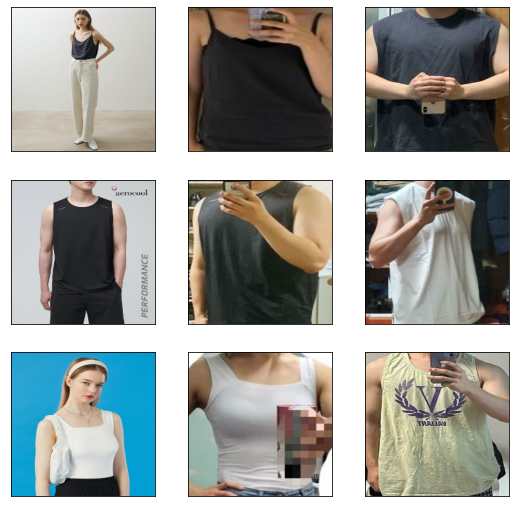

In [55]:
visualize(*list(train_dataset.take(1).as_numpy_iterator())[0])

In [56]:
callbacks = [EarlyStopping(monitor='val_loss', mode='auto', patience=12, restore_best_weights=True)]

In [57]:
siamese_model = SiameseModel(siamese_network)
siamese_model.compile(optimizer=tf.keras.optimizers.Adam(LEARNING_RATE), metrics=['accuracy'])
history = siamese_model.fit(train_dataset, epochs=EPOCHS, validation_data=val_dataset, callbacks=callbacks)

Epoch 1/100
3/3 [==============================] - ETA: 0s - loss: 0.4481

3/3 [==============================] - 17s 2s/step - loss: 0.4481 - val_loss: 0.4508
Epoch 2/100
3/3 [==============================] - ETA: 0s - loss: 0.3961

3/3 [==============================] - 1s 440ms/step - loss: 0.3961 - val_loss: 0.3132
Epoch 3/100
3/3 [==============================] - ETA: 0s - loss: 0.3493

3/3 [==============================] - 1s 332ms/step - loss: 0.3493 - val_loss: 0.3184
Epoch 4/100
3/3 [==============================] - ETA: 0s - loss: 0.3527

3/3 [==============================] - 1s 331ms/step - loss: 0.3527 - val_loss: 0.4405
Epoch 5/100
3/3 [==============================] - ETA: 0s - loss: 0.3730

3/3 [==============================] - 1s 332ms/step - loss: 0.3730 - val_loss: 0.4109
Epoch 6/100
3/3 [==============================] - ETA: 0s - loss: 0.3559

3/3 [==============================] - 1s 331ms/step - loss: 0.3559 - val_loss: 0.3167
Epoch 7/100
3/3 [==============================] - ETA: 0s - loss: 0.3409

3/3 [==============================] - 1s 437ms/step - loss: 0.3409 - val_loss: 0.2989
Epoch 8/100
3/3 [==============================] - ETA: 0s - loss: 0.3213

3/3 [==============================] - 1s 331ms/step - loss: 0.3213 - val_loss: 0.3845
Epoch 9/100
3/3 [==============================] - ETA: 0s - loss: 0.3571

3/3 [==============================] - 1s 332ms/step - loss: 0.3571 - val_loss: 0.4723
Epoch 10/100
3/3 [==============================] - ETA: 0s - loss: 0.3272

3/3 [==============================] - 1s 429ms/step - loss: 0.3272 - val_loss: 0.2802
Epoch 11/100
3/3 [==============================] - ETA: 0s - loss: 0.3045

3/3 [==============================] - 1s 435ms/step - loss: 0.3045 - val_loss: 0.2266
Epoch 12/100
3/3 [==============================] - ETA: 0s - loss: 0.3135

3/3 [==============================] - 1s 331ms/step - loss: 0.3135 - val_loss: 0.2641
Epoch 13/100
3/3 [==============================] - ETA: 0s - loss: 0.2784

3/3 [==============================] - 1s 333ms/step - loss: 0.2784 - val_loss: 0.2885
Epoch 14/100
3/3 [==============================] - ETA: 0s - loss: 0.2729

3/3 [==============================] - 1s 430ms/step - loss: 0.2729 - val_loss: 0.1728
Epoch 15/100
3/3 [==============================] - ETA: 0s - loss: 0.2298

3/3 [==============================] - 1s 332ms/step - loss: 0.2298 - val_loss: 0.2122
Epoch 16/100
3/3 [==============================] - ETA: 0s - loss: 0.2483

3/3 [==============================] - 1s 332ms/step - loss: 0.2483 - val_loss: 0.1831
Epoch 17/100
3/3 [==============================] - ETA: 0s - loss: 0.2240

3/3 [==============================] - 1s 332ms/step - loss: 0.2240 - val_loss: 0.1866
Epoch 18/100
3/3 [==============================] - ETA: 0s - loss: 0.2175

3/3 [==============================] - 1s 333ms/step - loss: 0.2175 - val_loss: 0.2128
Epoch 19/100
3/3 [==============================] - ETA: 0s - loss: 0.1999

3/3 [==============================] - 1s 437ms/step - loss: 0.1999 - val_loss: 0.1574
Epoch 20/100
3/3 [==============================] - ETA: 0s - loss: 0.1709

3/3 [==============================] - 1s 332ms/step - loss: 0.1709 - val_loss: 0.2203
Epoch 21/100
3/3 [==============================] - ETA: 0s - loss: 0.1900

3/3 [==============================] - 1s 332ms/step - loss: 0.1900 - val_loss: 0.1727
Epoch 22/100
3/3 [==============================] - ETA: 0s - loss: 0.1738

3/3 [==============================] - 1s 332ms/step - loss: 0.1738 - val_loss: 0.1838
Epoch 23/100
3/3 [==============================] - ETA: 0s - loss: 0.2044

3/3 [==============================] - 1s 332ms/step - loss: 0.2044 - val_loss: 0.2372
Epoch 24/100
3/3 [==============================] - ETA: 0s - loss: 0.1768

3/3 [==============================] - 1s 428ms/step - loss: 0.1768 - val_loss: 0.1435
Epoch 25/100
3/3 [==============================] - ETA: 0s - loss: 0.1619

3/3 [==============================] - 1s 331ms/step - loss: 0.1619 - val_loss: 0.1480
Epoch 26/100
3/3 [==============================] - ETA: 0s - loss: 0.1914

3/3 [==============================] - 1s 438ms/step - loss: 0.1914 - val_loss: 0.1264
Epoch 27/100
3/3 [==============================] - ETA: 0s - loss: 0.1448

3/3 [==============================] - 1s 429ms/step - loss: 0.1448 - val_loss: 0.0756
Epoch 28/100
3/3 [==============================] - ETA: 0s - loss: 0.1743

3/3 [==============================] - 1s 332ms/step - loss: 0.1743 - val_loss: 0.1640
Epoch 29/100
3/3 [==============================] - ETA: 0s - loss: 0.2127

3/3 [==============================] - 1s 331ms/step - loss: 0.2127 - val_loss: 0.4838
Epoch 30/100
3/3 [==============================] - ETA: 0s - loss: 0.3477

3/3 [==============================] - 1s 331ms/step - loss: 0.3477 - val_loss: 0.2821
Epoch 31/100
3/3 [==============================] - ETA: 0s - loss: 0.2581

3/3 [==============================] - 1s 332ms/step - loss: 0.2581 - val_loss: 0.2941
Epoch 32/100
3/3 [==============================] - ETA: 0s - loss: 0.2726

3/3 [==============================] - 1s 331ms/step - loss: 0.2726 - val_loss: 0.3593
Epoch 33/100
3/3 [==============================] - ETA: 0s - loss: 0.2978

3/3 [==============================] - 1s 332ms/step - loss: 0.2978 - val_loss: 0.2204
Epoch 34/100
3/3 [==============================] - ETA: 0s - loss: 0.2698

3/3 [==============================] - 1s 331ms/step - loss: 0.2698 - val_loss: 0.2440
Epoch 35/100
3/3 [==============================] - ETA: 0s - loss: 0.2456

3/3 [==============================] - 1s 332ms/step - loss: 0.2456 - val_loss: 0.2646
Epoch 36/100
3/3 [==============================] - ETA: 0s - loss: 0.2496

3/3 [==============================] - 1s 332ms/step - loss: 0.2496 - val_loss: 0.2471
Epoch 37/100
3/3 [==============================] - ETA: 0s - loss: 0.2405

3/3 [==============================] - 1s 331ms/step - loss: 0.2405 - val_loss: 0.2453
Epoch 38/100
3/3 [==============================] - ETA: 0s - loss: 0.2052

3/3 [==============================] - 1s 331ms/step - loss: 0.2052 - val_loss: 0.1781
Epoch 39/100
3/3 [==============================] - ETA: 0s - loss: 0.1857

3/3 [==============================] - 1s 414ms/step - loss: 0.1857 - val_loss: 0.1271


In [72]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

KeyError: ignored

In [59]:
sample = next(iter(train_dataset))
anchor, positive, negative = sample
anchor_embedding, positive_embedding, negative_embedding = (embedding(resnet.preprocess_input(anchor)), embedding(resnet.preprocess_input(positive)), embedding(resnet.preprocess_input(negative)),)

In [60]:
anchors, positives, negatives = sample
for i in range(len(anchor_embedding)):
    anchor, positive, negative = anchors[i], positives[i], negatives[i]
    positive_distance = np.linalg.norm(anchor_embedding[i] - positive_embedding[i], ord=2)*1e4
    negative_distance = np.linalg.norm(anchor_embedding[i] - negative_embedding[i], ord=2)*1e4
    positive_distance, negative_distance = round(positive_distance)/1e4, round(negative_distance)/1e4
    plt.figure(figsize=(16,9))
    plt.subplot(131)
    plt.imshow(anchor)
    plt.axis("off")
    plt.title("Anchor")
    plt.subplot(132)
    plt.imshow(positive)
    plt.axis("off")
    plt.title(f"Anchor to Positive Distance: {positive_distance}")
    plt.subplot(133)
    plt.imshow(negative)
    plt.axis("off")
    plt.title(f"Anchor to Negative Distance: {negative_distance}")
    plt.show()        

Output hidden; open in https://colab.research.google.com to view.

In [61]:
embedding.save("Midcateg_001011_1216.h5")

In [62]:
!cp Midcateg_001011_1216.h5 /content/drive/MyDrive/3rd_project/SiameseModels

## Inference
### 1. 002의 리뷰이미지들을 모두 불러와서 -> selection으로 대체
### 2. 모델 적용해 embedding 생성 
### 3. 각 상품에 대해 다른 상품들의 embedding과 비교해서 거리 생성
### 4. 거리 가장 작은 리뷰이미지의 midclass 조회
### 5. 본인 midclass가 4에서 예측한 midclass와 일치하는지 비교
### 6. 매트릭스 구성. 행과 열이 midclass 번호
### 7. midclass에 실제 속하는 리뷰 이미지, 예측된 리뷰이미지의 midclass 비율 confusion 매트릭스 구성

In [63]:
TARGET_SHAPE = (224,224,3)
def preprocess_image(filename: str):
    """
    Load the specified file as a JPEG image, preprocess it and
    resize it to the target shape.
    
    Args:
        filename: Absolute / Relative file path for the image
    
    Returns:
        Preprocessed inputs of type tensorflow.Tensor for Embedding Generation 
    """
    image_string = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, TARGET_SHAPE[:2])
    image = resnet.preprocess_input(image)
    return tf.expand_dims(image, axis=0)


def generate_embedding(dataframe, embedding_generator):
    """
    Use the specified dataframe and Embeddings model to 
    calculate embeddings for all records in the dataframe
    
    Args:
        dataframe: Dataframe to get records for Embedding Generation
        embedding_genrator: Tensorflow Model to generate embeddings
    
    Returns:
        Dataframe with embeddings for each record.
    """
    embeddings_review = list()
    for i, row in tqdm(dataframe.iterrows(), total=dataframe.shape[0]):
        filename = row["review_path_drive"]
        image = preprocess_image(filename)
        embedding = embedding_generator(image)
        embeddings_review.append(embedding[0].numpy().astype(np.float32).tolist())
    dataframe["embedding_review"] = embeddings_review
    embeddings_sample = list()
    for i, row in tqdm(dataframe.iterrows(), total=dataframe.shape[0]):
        filename = row["sample_path_drive"]
        image = preprocess_image(filename)
        embedding = embedding_generator(image)
        embeddings_sample.append(embedding[0].numpy().astype(np.float32).tolist())
    dataframe["embedding_sample"] = embeddings_sample
    return dataframe

In [64]:
Midclass001011 = load_model("/content/drive/MyDrive/3rd_project/SiameseModels/Midcateg_001011_1216.h5", compile=False)

In [65]:
df_styleReview_001011 = pd.read_csv("/content/drive/MyDrive/3rd_project/df_styleReview_001011.csv", dtype=object)
df_styleReview_001011

,level_0,goods_id_pure,index,filename,width,height,xmin,ymin,xmax,ymax,goods_id,mid_category,goods_image,sample_path_local,review_path_local,sample_path_drive,review_path_drive,anchor,positive,negative
0,12,87864,4271,87864_0_gallery_638823f59bcf7_jpg.rf.2c36c38ab...,93,181,0,0,93,181,87864,001011,https://image.msscdn.net/images/goods_img/2014...,C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...,C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...
1,13,87867,1744,87867_0_gallery_630e38a68dfeb_jpg.rf.f336ef8d3...,134,258,0,0,134,258,87867,001011,https://image.msscdn.net/images/goods_img/2014...,C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...,C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...
2,60,209988,287,209988_0_gallery_5d9450e73a334_jpg.rf.0cf134ec...,424,581,0,0,424,581,209988,001011,https://image.msscdn.net/images/goods_img/2015...,C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...,C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...
3,62,214825,168,214825_0_gallery_5d6878327175c_jpg.rf.07d7eddb...,290,356,0,0,290,356,214825,001011,https://image.msscdn.net/images/goods_img/2015...,C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...,C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...
4,63,214825,1795,214825_0_gallery_57d7d1a88f3db_jpg.rf.f5f8e70d...,235,349,0,0,235,349,214825,001011,https://image.msscdn.net/images/goods_img/2015...,C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...,C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206,4544,2687086,2390,2687086_0_gallery_637976cc8a424_jpg.rf.9139ef4...,279,322,0,0,279,322,2687086,001011,https://image.msscdn.net/images/goods_img/2022...,C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...,C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...
207,4545,2687101,2914,2687101_0_gallery_6312f8afe5eeb_jpg.rf.699afec...,277,410,0,0,277,410,2687101,001011,https://image.msscdn.net/images/goods_img/2022...,C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...,C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...
208,4549,2688452,1657,2688452_0_gallery_631ee3d6d14a0_jpg.rf.ee128dc...,321,394,0,0,321,394,2688452,001011,https://image.msscdn.net/images/goods_img/2022...,C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1

In [66]:
df_styleReview_001011_sim = generate_embedding(df_styleReview_001011, Midclass001011)
df_styleReview_001011_sim.to_csv("/content/drive/MyDrive/3rd_project/df_styleReview_001011_sim.csv", index=False)
df_styleReview_001011_sim = pd.read_csv("/content/drive/MyDrive/3rd_project/df_styleReview_001011_sim.csv", dtype=object)

100%|██████████| 211/211 [00:15<00:00, 13.90it/s]


In [67]:
df_styleReview_001011_sim

,level_0,goods_id_pure,index,filename,width,height,xmin,ymin,xmax,ymax,...,goods_image,sample_path_local,review_path_local,sample_path_drive,review_path_drive,anchor,positive,negative,embedding_review,embedding_sample
0,12,87864,4271,87864_0_gallery_638823f59bcf7_jpg.rf.2c36c38ab...,93,181,0,0,93,181,...,https://image.msscdn.net/images/goods_img/2014...,C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...,C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...,"[-84.20262908935547, -59.35416030883789, -15.8...","[-84.3206558227539, -59.28608322143555, -15.74..."
1,13,87867,1744,87867_0_gallery_630e38a68dfeb_jpg.rf.f336ef8d3...,134,258,0,0,134,258,...,https://image.msscdn.net/images/goods_img/2014...,C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...,C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...,"[-84.21431732177734, -59.26618957519531, -15.7...","[-84.02522277832031, -59.113765716552734, -15...."
2,60,209988,287,209988_0_gallery_5d9450e73a334_jpg.rf.0cf134ec...,424,581,0,0,424,581,...,https://image.msscdn.net/images/goods_img/2015...,C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...,C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...,"[-84.40909576416016, -59.35529708862305, -15.8...","[-84.52439880371094, -59.312278747558594, -15...."
3,62,214825,168,214825_0_gallery_5d6878327175c_jpg.rf.07d7eddb...,290,356,0,0,290,356,...,https://image.msscdn.net/images/goods_img/2015...,C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...,C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...,"[-84.28611755371094, -59.344486236572266, -15....","[-84.40016174316406, -59.22821044921875, -15.7..."
4,63,214825,1795,214825_0_gallery_57d7d1a88f3db_jpg.rf.f5f8e70d...,235,349,0,0,235,349,...,https://image.msscdn.net/images/goods_img/2015...,C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...,C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...,"[-84.3149185180664, -59.30304718017578, -15.75...","[-84.40016174316406, -59.22821044921875, -15.7..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206,4544,2687086,2390,2687086_0_gallery_637976cc8a424_jpg.rf.9139ef4...,279,322,0,0,279,322,...,https://image.msscdn.net/images/goods_img/2022...,C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...,C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...,"[-83.9525146484375, -59.16147994995117, -15.62...","[-83.79146575927734, -58.96390151977539, -15.4..."
207,4545,2687101,2914,2687101_0_gallery_6312f8afe5eeb_jpg.rf.699afec...,277,410,0,0,277,410,...,https://image.msscdn.net/imag

임의의 행의 리리

100%|██████████| 211/211 [00:00<00:00, 920.20it/s]


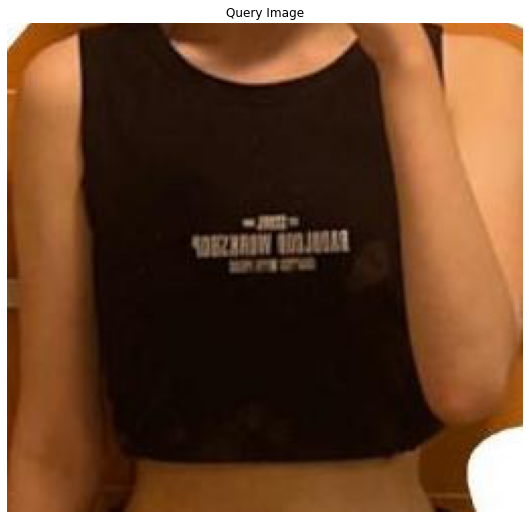

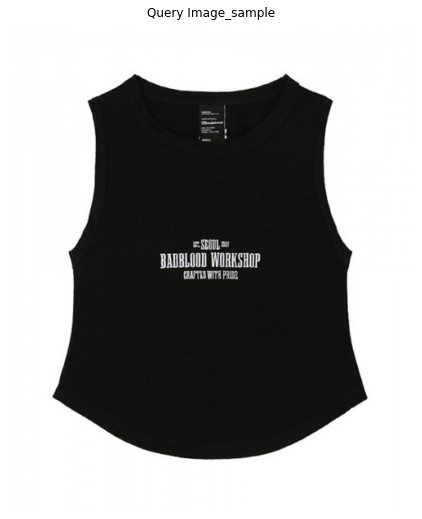

2503565


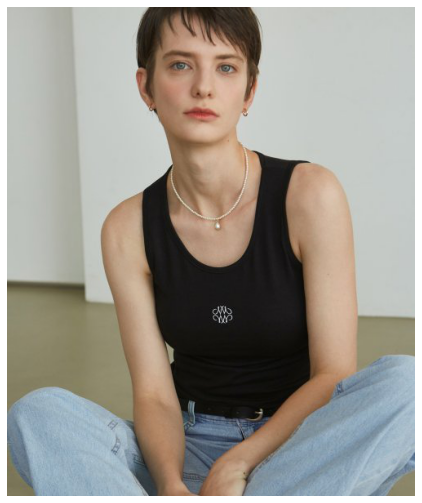

유사도 :  0.39276328682899475
2606099
Shop Now @  https://musinsa.com/app/goods/2606099


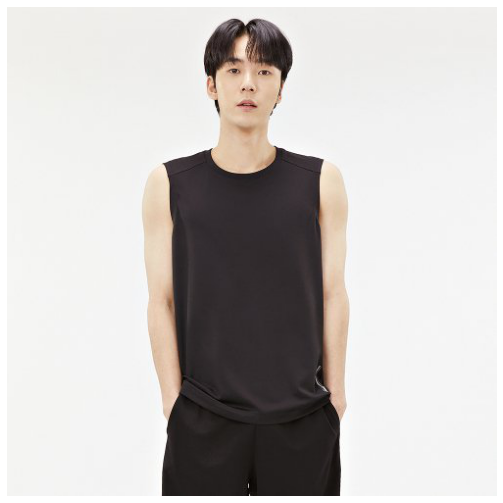

유사도 :  0.4959595799446106
1948723
Shop Now @  https://musinsa.com/app/goods/1948723


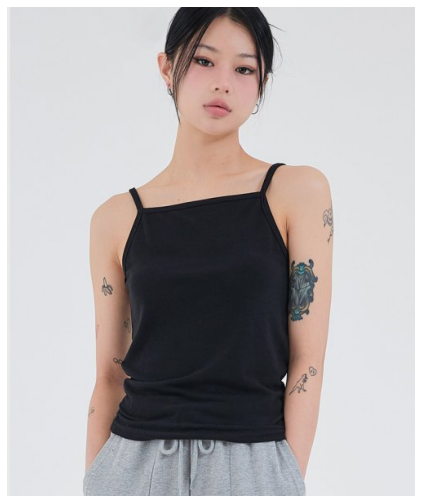

유사도 :  0.5173164010047913
1917557
Shop Now @  https://musinsa.com/app/goods/1917557


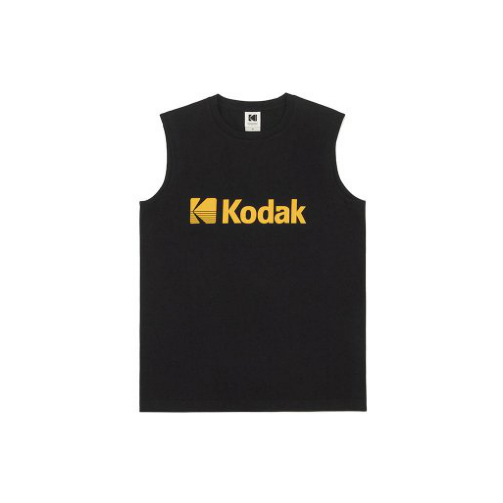

유사도 :  0.5299705266952515
2560534
Shop Now @  https://musinsa.com/app/goods/2560534


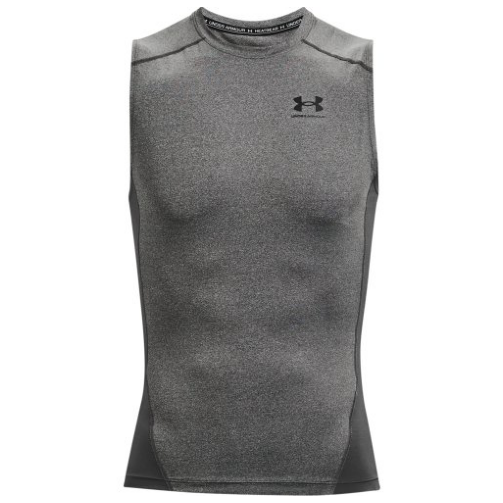

유사도 :  0.5304662585258484
1838931
Shop Now @  https://musinsa.com/app/goods/1838931


In [68]:
 tqdm.pandas()
query_row = df_styleReview_001011_sim.iloc[random.randint(0,df_styleReview_001011_sim.shape[0])] 
query_embedding = query_row.embedding_review
a = query_row["goods_id_pure"] 
b = query_row.review_path_drive
c = query_row.sample_path_drive
df_styleReview_001011_sim['distance_samImg_queryRev'] = df_styleReview_001011_sim['embedding_sample'].progress_apply(lambda x: np.linalg.norm(np.asarray(eval(x), dtype=np.float32) - np.asarray(eval(query_embedding), dtype=np.float32)))
df_styleReview_001011_sim = df_styleReview_001011_sim.sort_values(by='distance_samImg_queryRev').reset_index(drop=True)
plt.figure(figsize=(16,9))
plt.imshow(io.imread(b))
plt.title("Query Image")
plt.axis("off");plt.show()
plt.figure(figsize=(16,9))
plt.imshow(io.imread(c))
plt.title("Query Image_sample")
plt.axis("off");plt.show()
print(a)
print(254*"=")
print(254*"=")
j = 0
for i, row in df_styleReview_001011_sim.drop_duplicates("goods_id_pure",inplace=False).iloc[:5, :].iterrows():
    j += 1
    plt.figure(figsize=(16,9))
    image = io.imread(row["sample_path_drive"])
    plt.imshow(image);plt.axis("off")
    plt.show()
    print("유사도 : ", row["distance_samImg_queryRev"])
    print(row["goods_id_pure"])
    if a == row["goods_id_pure"] :
      print(j, "번 째 일치")
    print("Shop Now @ ", ("https://musinsa.com/app/goods/" + row["goods_id_pure"]))


In [69]:
df_styleReview_001011_sim = pd.read_csv("/content/drive/MyDrive/3rd_project/df_styleReview_001011_sim.csv", dtype=object)
df_styleReview_001011_sim 

,level_0,goods_id_pure,index,filename,width,height,xmin,ymin,xmax,ymax,...,goods_image,sample_path_local,review_path_local,sample_path_drive,review_path_drive,anchor,positive,negative,embedding_review,embedding_sample
0,12,87864,4271,87864_0_gallery_638823f59bcf7_jpg.rf.2c36c38ab...,93,181,0,0,93,181,...,https://image.msscdn.net/images/goods_img/2014...,C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...,C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...,"[-84.20262908935547, -59.35416030883789, -15.8...","[-84.3206558227539, -59.28608322143555, -15.74..."
1,13,87867,1744,87867_0_gallery_630e38a68dfeb_jpg.rf.f336ef8d3...,134,258,0,0,134,258,...,https://image.msscdn.net/images/goods_img/2014...,C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...,C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...,"[-84.21431732177734, -59.26618957519531, -15.7...","[-84.02522277832031, -59.113765716552734, -15...."
2,60,209988,287,209988_0_gallery_5d9450e73a334_jpg.rf.0cf134ec...,424,581,0,0,424,581,...,https://image.msscdn.net/images/goods_img/2015...,C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...,C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...,"[-84.40909576416016, -59.35529708862305, -15.8...","[-84.52439880371094, -59.312278747558594, -15...."
3,62,214825,168,214825_0_gallery_5d6878327175c_jpg.rf.07d7eddb...,290,356,0,0,290,356,...,https://image.msscdn.net/images/goods_img/2015...,C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...,C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...,"[-84.28611755371094, -59.344486236572266, -15....","[-84.40016174316406, -59.22821044921875, -15.7..."
4,63,214825,1795,214825_0_gallery_57d7d1a88f3db_jpg.rf.f5f8e70d...,235,349,0,0,235,349,...,https://image.msscdn.net/images/goods_img/2015...,C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...,C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...,"[-84.3149185180664, -59.30304718017578, -15.75...","[-84.40016174316406, -59.22821044921875, -15.7..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206,4544,2687086,2390,2687086_0_gallery_637976cc8a424_jpg.rf.9139ef4...,279,322,0,0,279,322,...,https://image.msscdn.net/images/goods_img/2022...,C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...,C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...,"[-83.9525146484375, -59.16147994995117, -15.62...","[-83.79146575927734, -58.96390151977539, -15.4..."
207,4545,2687101,2914,2687101_0_gallery_6312f8afe5eeb_jpg.rf.699afec...,277,410,0,0,277,410,...,https://image.msscdn.net/imag

In [70]:
for i, row in df_styleReview_001011_sim.iterrows(): # 리뷰 사진 임베딩 기준 
    row_embedding = row.embedding_review
    df_styleReview_001011_sim['distance_{}'.format(row.positive)] = df_styleReview_001011_sim['embedding_review']\
    .progress_apply(lambda x: np.linalg.norm(np.asarray(eval(x), dtype=np.float32) - np.asarray(eval(row_embedding), dtype=np.float32)))
    # row * row
    print(i, "완료")
df_styleReview_001011_sim

100%|██████████| 211/211 [00:00<00:00, 936.07it/s]


0 완료


100%|██████████| 211/211 [00:00<00:00, 926.90it/s]


1 완료


100%|██████████| 211/211 [00:00<00:00, 931.02it/s]


2 완료


100%|██████████| 211/211 [00:00<00:00, 915.94it/s]


3 완료


100%|██████████| 211/211 [00:00<00:00, 931.27it/s]


4 완료


100%|██████████| 211/211 [00:00<00:00, 928.21it/s]


5 완료


100%|██████████| 211/211 [00:00<00:00, 940.13it/s]


6 완료


100%|██████████| 211/211 [00:00<00:00, 909.41it/s]


7 완료


100%|██████████| 211/211 [00:00<00:00, 913.77it/s]


8 완료


100%|██████████| 211/211 [00:00<00:00, 919.12it/s]


9 완료


100%|██████████| 211/211 [00:00<00:00, 934.62it/s]


10 완료


100%|██████████| 211/211 [00:00<00:00, 931.70it/s]


11 완료


100%|██████████| 211/211 [00:00<00:00, 940.03it/s]


12 완료


100%|██████████| 211/211 [00:00<00:00, 933.89it/s]


13 완료


100%|██████████| 211/211 [00:00<00:00, 936.28it/s]


14 완료


100%|██████████| 211/211 [00:00<00:00, 923.02it/s]


15 완료


100%|██████████| 211/211 [00:00<00:00, 920.89it/s]


16 완료


100%|██████████| 211/211 [00:00<00:00, 926.37it/s]


17 완료


100%|██████████| 211/211 [00:00<00:00, 927.19it/s]


18 완료


100%|██████████| 211/211 [00:00<00:00, 910.91it/s]


19 완료


100%|██████████| 211/211 [00:00<00:00, 882.58it/s]


20 완료


100%|██████████| 211/211 [00:00<00:00, 935.57it/s]


21 완료


100%|██████████| 211/211 [00:00<00:00, 934.93it/s]


22 완료


100%|██████████| 211/211 [00:00<00:00, 912.48it/s]


23 완료


100%|██████████| 211/211 [00:00<00:00, 921.93it/s]


24 완료


100%|██████████| 211/211 [00:00<00:00, 930.18it/s]


25 완료


100%|██████████| 211/211 [00:00<00:00, 916.82it/s]


26 완료


100%|██████████| 211/211 [00:00<00:00, 919.30it/s]


27 완료


100%|██████████| 211/211 [00:00<00:00, 920.71it/s]


28 완료


100%|██████████| 211/211 [00:00<00:00, 936.12it/s]


29 완료


100%|██████████| 211/211 [00:00<00:00, 913.76it/s]


30 완료


100%|██████████| 211/211 [00:00<00:00, 938.50it/s]


31 완료


100%|██████████| 211/211 [00:00<00:00, 934.78it/s]


32 완료


100%|██████████| 211/211 [00:00<00:00, 923.50it/s]


33 완료


100%|██████████| 211/211 [00:00<00:00, 926.82it/s]


34 완료


100%|██████████| 211/211 [00:00<00:00, 926.67it/s]


35 완료


100%|██████████| 211/211 [00:00<00:00, 934.84it/s]


36 완료


100%|██████████| 211/211 [00:00<00:00, 918.56it/s]


37 완료


100%|██████████| 211/211 [00:00<00:00, 936.38it/s]


38 완료


100%|██████████| 211/211 [00:00<00:00, 922.34it/s]


39 완료


100%|██████████| 211/211 [00:00<00:00, 929.62it/s]


40 완료


100%|██████████| 211/211 [00:00<00:00, 916.32it/s]


41 완료


100%|██████████| 211/211 [00:00<00:00, 939.36it/s]


42 완료


100%|██████████| 211/211 [00:00<00:00, 934.05it/s]


43 완료


100%|██████████| 211/211 [00:00<00:00, 923.87it/s]


44 완료


100%|██████████| 211/211 [00:00<00:00, 926.61it/s]


45 완료


100%|██████████| 211/211 [00:00<00:00, 926.90it/s]


46 완료


100%|██████████| 211/211 [00:00<00:00, 923.17it/s]


47 완료


100%|██████████| 211/211 [00:00<00:00, 926.82it/s]


48 완료


100%|██████████| 211/211 [00:00<00:00, 922.86it/s]


49 완료


100%|██████████| 211/211 [00:00<00:00, 922.71it/s]


50 완료


100%|██████████| 211/211 [00:00<00:00, 931.04it/s]


51 완료


100%|██████████| 211/211 [00:00<00:00, 923.15it/s]


52 완료


100%|██████████| 211/211 [00:00<00:00, 932.00it/s]


53 완료


100%|██████████| 211/211 [00:00<00:00, 934.39it/s]


54 완료


100%|██████████| 211/211 [00:00<00:00, 915.62it/s]


55 완료


100%|██████████| 211/211 [00:00<00:00, 908.60it/s]


56 완료


100%|██████████| 211/211 [00:00<00:00, 928.61it/s]


57 완료


100%|██████████| 211/211 [00:00<00:00, 927.76it/s]


58 완료


100%|██████████| 211/211 [00:00<00:00, 924.57it/s]


59 완료


100%|██████████| 211/211 [00:00<00:00, 929.09it/s]


60 완료


100%|██████████| 211/211 [00:00<00:00, 925.42it/s]


61 완료


100%|██████████| 211/211 [00:00<00:00, 924.92it/s]


62 완료


100%|██████████| 211/211 [00:00<00:00, 933.27it/s]


63 완료


100%|██████████| 211/211 [00:00<00:00, 869.13it/s]


64 완료


100%|██████████| 211/211 [00:00<00:00, 920.07it/s]


65 완료


100%|██████████| 211/211 [00:00<00:00, 934.95it/s]


66 완료


100%|██████████| 211/211 [00:00<00:00, 929.50it/s]


67 완료


100%|██████████| 211/211 [00:00<00:00, 925.67it/s]


68 완료


100%|██████████| 211/211 [00:00<00:00, 929.66it/s]


69 완료


100%|██████████| 211/211 [00:00<00:00, 926.39it/s]


70 완료


100%|██████████| 211/211 [00:00<00:00, 932.15it/s]


71 완료


100%|██████████| 211/211 [00:00<00:00, 928.86it/s]


72 완료


100%|██████████| 211/211 [00:00<00:00, 933.28it/s]


73 완료


100%|██████████| 211/211 [00:00<00:00, 930.16it/s]


74 완료


100%|██████████| 211/211 [00:00<00:00, 923.39it/s]


75 완료


100%|██████████| 211/211 [00:00<00:00, 919.05it/s]


76 완료


100%|██████████| 211/211 [00:00<00:00, 908.08it/s]


77 완료


100%|██████████| 211/211 [00:00<00:00, 931.88it/s]


78 완료


100%|██████████| 211/211 [00:00<00:00, 916.92it/s]


79 완료


100%|██████████| 211/211 [00:00<00:00, 928.17it/s]


80 완료


100%|██████████| 211/211 [00:00<00:00, 927.33it/s]


81 완료


100%|██████████| 211/211 [00:00<00:00, 938.66it/s]


82 완료


100%|██████████| 211/211 [00:00<00:00, 925.60it/s]


83 완료


100%|██████████| 211/211 [00:00<00:00, 925.29it/s]


84 완료


100%|██████████| 211/211 [00:00<00:00, 927.50it/s]


85 완료


100%|██████████| 211/211 [00:00<00:00, 924.98it/s]


86 완료


100%|██████████| 211/211 [00:00<00:00, 931.49it/s]


87 완료


100%|██████████| 211/211 [00:00<00:00, 931.79it/s]


88 완료


100%|██████████| 211/211 [00:00<00:00, 923.43it/s]


89 완료


100%|██████████| 211/211 [00:00<00:00, 875.79it/s]


90 완료


100%|██████████| 211/211 [00:00<00:00, 933.02it/s]


91 완료


100%|██████████| 211/211 [00:00<00:00, 919.43it/s]


92 완료


100%|██████████| 211/211 [00:00<00:00, 939.73it/s]


93 완료


100%|██████████| 211/211 [00:00<00:00, 938.53it/s]


94 완료


100%|██████████| 211/211 [00:00<00:00, 931.57it/s]


95 완료


100%|██████████| 211/211 [00:00<00:00, 933.20it/s]


96 완료


100%|██████████| 211/211 [00:00<00:00, 937.19it/s]


97 완료


100%|██████████| 211/211 [00:00<00:00, 933.57it/s]


98 완료


100%|██████████| 211/211 [00:00<00:00, 925.99it/s]


99 완료


100%|██████████| 211/211 [00:00<00:00, 923.05it/s]


100 완료


100%|██████████| 211/211 [00:00<00:00, 927.35it/s]


101 완료


100%|██████████| 211/211 [00:00<00:00, 943.72it/s]


102 완료


100%|██████████| 211/211 [00:00<00:00, 928.84it/s]


103 완료


100%|██████████| 211/211 [00:00<00:00, 940.69it/s]


104 완료


100%|██████████| 211/211 [00:00<00:00, 920.26it/s]


105 완료


100%|██████████| 211/211 [00:00<00:00, 943.00it/s]


106 완료


100%|██████████| 211/211 [00:00<00:00, 929.10it/s]


107 완료


100%|██████████| 211/211 [00:00<00:00, 922.48it/s]


108 완료


100%|██████████| 211/211 [00:00<00:00, 911.66it/s]


109 완료


100%|██████████| 211/211 [00:00<00:00, 924.93it/s]


110 완료


100%|██████████| 211/211 [00:00<00:00, 932.49it/s]


111 완료


100%|██████████| 211/211 [00:00<00:00, 920.32it/s]


112 완료


100%|██████████| 211/211 [00:00<00:00, 925.80it/s]


113 완료


100%|██████████| 211/211 [00:00<00:00, 921.63it/s]


114 완료


100%|██████████| 211/211 [00:00<00:00, 929.35it/s]


115 완료


100%|██████████| 211/211 [00:00<00:00, 908.24it/s]


116 완료


100%|██████████| 211/211 [00:00<00:00, 926.58it/s]


117 완료


100%|██████████| 211/211 [00:00<00:00, 923.94it/s]


118 완료


100%|██████████| 211/211 [00:00<00:00, 932.05it/s]


119 완료


100%|██████████| 211/211 [00:00<00:00, 927.81it/s]


120 완료


100%|██████████| 211/211 [00:00<00:00, 942.37it/s]


121 완료


100%|██████████| 211/211 [00:00<00:00, 937.97it/s]


122 완료


100%|██████████| 211/211 [00:00<00:00, 930.19it/s]


123 완료


100%|██████████| 211/211 [00:00<00:00, 930.75it/s]


124 완료


100%|██████████| 211/211 [00:00<00:00, 920.08it/s]


125 완료


100%|██████████| 211/211 [00:00<00:00, 925.83it/s]


126 완료


100%|██████████| 211/211 [00:00<00:00, 924.20it/s]


127 완료


100%|██████████| 211/211 [00:00<00:00, 937.83it/s]


128 완료


100%|██████████| 211/211 [00:00<00:00, 931.26it/s]


129 완료


100%|██████████| 211/211 [00:00<00:00, 930.21it/s]


130 완료


100%|██████████| 211/211 [00:00<00:00, 913.33it/s]


131 완료


100%|██████████| 211/211 [00:00<00:00, 929.94it/s]


132 완료


100%|██████████| 211/211 [00:00<00:00, 889.56it/s]


133 완료


100%|██████████| 211/211 [00:00<00:00, 919.10it/s]


134 완료


100%|██████████| 211/211 [00:00<00:00, 922.91it/s]


135 완료


100%|██████████| 211/211 [00:00<00:00, 920.28it/s]


136 완료


100%|██████████| 211/211 [00:00<00:00, 927.51it/s]


137 완료


100%|██████████| 211/211 [00:00<00:00, 918.79it/s]


138 완료


100%|██████████| 211/211 [00:00<00:00, 920.68it/s]


139 완료


100%|██████████| 211/211 [00:00<00:00, 923.94it/s]


140 완료


100%|██████████| 211/211 [00:00<00:00, 935.71it/s]


141 완료


100%|██████████| 211/211 [00:00<00:00, 931.74it/s]


142 완료


100%|██████████| 211/211 [00:00<00:00, 922.75it/s]


143 완료


100%|██████████| 211/211 [00:00<00:00, 928.72it/s]


144 완료


100%|██████████| 211/211 [00:00<00:00, 925.04it/s]


145 완료


100%|██████████| 211/211 [00:00<00:00, 924.65it/s]


146 완료


100%|██████████| 211/211 [00:00<00:00, 934.30it/s]


147 완료


100%|██████████| 211/211 [00:00<00:00, 924.54it/s]


148 완료


100%|██████████| 211/211 [00:00<00:00, 921.89it/s]


149 완료


100%|██████████| 211/211 [00:00<00:00, 917.22it/s]


150 완료


100%|██████████| 211/211 [00:00<00:00, 921.78it/s]


151 완료


100%|██████████| 211/211 [00:00<00:00, 916.71it/s]


152 완료


100%|██████████| 211/211 [00:00<00:00, 928.94it/s]


153 완료


100%|██████████| 211/211 [00:00<00:00, 921.72it/s]


154 완료


100%|██████████| 211/211 [00:00<00:00, 940.98it/s]


155 완료


100%|██████████| 211/211 [00:00<00:00, 941.40it/s]


156 완료


100%|██████████| 211/211 [00:00<00:00, 941.07it/s]


157 완료


100%|██████████| 211/211 [00:00<00:00, 916.84it/s]


158 완료


100%|██████████| 211/211 [00:00<00:00, 893.57it/s]


159 완료


100%|██████████| 211/211 [00:00<00:00, 926.65it/s]


160 완료


100%|██████████| 211/211 [00:00<00:00, 928.60it/s]


161 완료


100%|██████████| 211/211 [00:00<00:00, 924.52it/s]


162 완료


100%|██████████| 211/211 [00:00<00:00, 911.09it/s]


163 완료


100%|██████████| 211/211 [00:00<00:00, 924.11it/s]


164 완료


100%|██████████| 211/211 [00:00<00:00, 939.91it/s]


165 완료


100%|██████████| 211/211 [00:00<00:00, 934.47it/s]


166 완료


100%|██████████| 211/211 [00:00<00:00, 939.32it/s]


167 완료


100%|██████████| 211/211 [00:00<00:00, 918.43it/s]


168 완료


100%|██████████| 211/211 [00:00<00:00, 938.12it/s]


169 완료


100%|██████████| 211/211 [00:00<00:00, 928.83it/s]


170 완료


100%|██████████| 211/211 [00:00<00:00, 921.13it/s]


171 완료


100%|██████████| 211/211 [00:00<00:00, 926.52it/s]


172 완료


100%|██████████| 211/211 [00:00<00:00, 915.70it/s]


173 완료


100%|██████████| 211/211 [00:00<00:00, 944.58it/s]


174 완료


100%|██████████| 211/211 [00:00<00:00, 900.12it/s]


175 완료


100%|██████████| 211/211 [00:00<00:00, 913.93it/s]


176 완료


100%|██████████| 211/211 [00:00<00:00, 926.70it/s]


177 완료


100%|██████████| 211/211 [00:00<00:00, 939.99it/s]


178 완료


100%|██████████| 211/211 [00:00<00:00, 922.22it/s]


179 완료


100%|██████████| 211/211 [00:00<00:00, 919.70it/s]


180 완료


100%|██████████| 211/211 [00:00<00:00, 943.17it/s]


181 완료


100%|██████████| 211/211 [00:00<00:00, 933.17it/s]


182 완료


100%|██████████| 211/211 [00:00<00:00, 942.33it/s]


183 완료


100%|██████████| 211/211 [00:00<00:00, 932.00it/s]


184 완료


100%|██████████| 211/211 [00:00<00:00, 929.25it/s]


185 완료


100%|██████████| 211/211 [00:00<00:00, 942.50it/s]


186 완료


100%|██████████| 211/211 [00:00<00:00, 932.94it/s]


187 완료


100%|██████████| 211/211 [00:00<00:00, 936.88it/s]


188 완료


100%|██████████| 211/211 [00:00<00:00, 911.37it/s]


189 완료


100%|██████████| 211/211 [00:00<00:00, 938.31it/s]


190 완료


100%|██████████| 211/211 [00:00<00:00, 924.68it/s]


191 완료


100%|██████████| 211/211 [00:00<00:00, 932.84it/s]


192 완료


100%|██████████| 211/211 [00:00<00:00, 931.01it/s]


193 완료


100%|██████████| 211/211 [00:00<00:00, 917.66it/s]


194 완료


100%|██████████| 211/211 [00:00<00:00, 931.66it/s]


195 완료


100%|██████████| 211/211 [00:00<00:00, 933.48it/s]


196 완료


100%|██████████| 211/211 [00:00<00:00, 929.40it/s]


197 완료


100%|██████████| 211/211 [00:00<00:00, 937.99it/s]


198 완료


100%|██████████| 211/211 [00:00<00:00, 929.44it/s]


199 완료


100%|██████████| 211/211 [00:00<00:00, 936.82it/s]


200 완료


100%|██████████| 211/211 [00:00<00:00, 918.74it/s]


201 완료


100%|██████████| 211/211 [00:00<00:00, 929.79it/s]


202 완료


100%|██████████| 211/211 [00:00<00:00, 874.54it/s]


203 완료


100%|██████████| 211/211 [00:00<00:00, 914.05it/s]


204 완료


100%|██████████| 211/211 [00:00<00:00, 935.66it/s]


205 완료


100%|██████████| 211/211 [00:00<00:00, 927.22it/s]


206 완료


100%|██████████| 211/211 [00:00<00:00, 924.42it/s]


207 완료


100%|██████████| 211/211 [00:00<00:00, 939.25it/s]


208 완료


100%|██████████| 211/211 [00:00<00:00, 928.12it/s]


209 완료


100%|██████████| 211/211 [00:00<00:00, 938.23it/s]

210 완료


,level_0,goods_id_pure,index,filename,width,height,xmin,ymin,xmax,ymax,...,distance_/content/drive/Othercomputers/내 노트북/12sw_project.v4i.tensorflow/train/2671673_0_gallery_63780d9292a8f_jpg.rf.50ceb0da4a3132c98127468893cebeda.jpg,distance_/content/drive/Othercomputers/내 노트북/12sw_project.v4i.tensorflow/train/2672798_0_gallery_63770b4aa30e5_jpg.rf.598966e073bac2647d78c1e97ee3817e.jpg,distance_/content/drive/Othercomputers/내 노트북/12sw_project.v4i.tensorflow/train/2679524_0_gallery_62f4f6f46e0ce_jpg.rf.015cb08570ac7926e658d8faecb0f4eb.jpg,distance_/content/drive/Othercomputers/내 노트북/12sw_project.v4i.tensorflow/train/2679524_0_gallery_635e805cde92e_jpg.rf.f0fecde20fb51fc3cb4d31b9001951e2.jpg,distance_/content/drive/Othercomputers/내 노트북/12sw_project.v4i.tensorflow/train/2687086_0_gallery_637a40b621292_jpg.rf.325ce724740089509c0b91a4379819fc.jpg,distance_/content/drive/Othercomputers/내 노트북/12sw_project.v4i.tensorflow/train/2687086_0_gallery_637976cc8a424_jpg.rf.9139ef4781325f9147fc079997b4a03e.jpg,distance_/content/drive/Othercomputers/내 노트북/12sw_project.v4i.tensorflow/train/2687101_0_gallery_6312f8afe5eeb_jpg.rf.699afec201455cbe99084e015a711c19.jpg,distance_/content/drive/Othercomputers/내 노트북/12sw_project.v4i.tensorflow/train/2688452_0_gallery_631ee3d6d14a0_jpg.rf.ee128dc661677c31521ba56433c99fe5.jpg,distance_/content/drive/Othercomputers/내 노트북/12sw_project.v4i.tensorflow/train/2688452_0_gallery_636da5399bd9c_jpg.rf.014a82f562b5620f196ec0cf898dd304.jpg,distance_/content/drive/Othercomputers/내 노트북/12sw_project.v4i.tensorflow/train/2877568_0_gallery_6380d4fa80eb9_jpg.rf.fb756280317083495d2b8a330f269836.jpg
0,12,87864,4271,87864_0_gallery_638823f59bcf7_jpg.rf.2c36c38ab...,93,181,0,0,93,181,...,0.872327,0.571651,0.914466,1.211273,0.750360,2.716468,1.044205,2.268341,2.670852,1.041494
1,13,87867,1744,87867_0_gallery_630e38a68dfeb_jpg.rf.f336ef8d3...,134,258,0,0,134,258,...,1.523970,1.517534,1.347478,0.802835,0.919204,1.952516,0.841219,1.636150,1.913798,1.791021
2,60,209988,287,209988_0_gallery_5d9450e73a334_jpg.rf.0cf134ec...,424,581,0,0,424,581,...,0.573896,0.899399,0.372097,1.051273,1.193803,3.249518,1.396493,2.744397,3.093053,0.641185
3,62,214825,168,214825_0_gallery_5d6878327175c_jpg.rf.07d7eddb...,290,356,0,0,290,356,...,0.617198,0.736596,0.591636,0.844343,0.809396,2.804606,0.971103,2.257522,2.695941,0.838540
4,63,214825,1795,214825_0_gallery_57d7d1a88f3db_jpg.rf.f5f8e70d...,235,349,0,0,235,349,...,0.837883,1.024012,0.686835,0.624943,0.831783,2.645977,0.930892,2.158747,2.493372,1.072329
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206,4544,2687086,2390,2687086_0_gallery_637976cc8a424_jpg.rf.9139ef4...,279,322,0,0,279,322,...,3.263347,2.985227,3.130846,2.579704,2.239751,0.000000,2.258031,1.540396,1.094516,3.509642
207,4545,2687101,2914,2687101_0_gallery_6312f8afe5eeb_jpg.rf.699afec...,277,410,0,0,277,410,...,1.274244,1.317371,1.356198,0.838566,1.085163,2.258031,0.000000,1.494007,2.241488,1.604683
208,4549,2688452,1657,2688452_0_gallery_631ee3d6d14a0_jpg.rf.ee128dc...,321,394,0,0,321,394,...,2.606949,2.533617,2.695593,1.963326,2.041600,1.540396,1.494007,0.000000,1.606603,2.925129
209,4550,2688452,27,2688452_0_gallery_636da5399bd9c_jpg.rf.014a82f...,189,164,0,0,189,164,...,3.075318,2.819720,2.989230,2.525913,2.146252,1.094516,2.241488,1.606603,0.000000,3.279693


In [71]:
df_styleReview_001011_sim.to_csv("/content/drive/MyDrive/3rd_project/df_styleReview_001011_sim_matrix.csv", index=False)

In [ ]:
df_styleReview_001005_sim_matrix = pd.read_csv("/content/drive/MyDrive/3rd_project/df_styleReview_001005_sim_matrix.csv", dtype=object)

In [ ]:
df_styleReview_001005_sim_matrix

,level_0,goods_id_pure,index,filename,width,height,xmin,ymin,xmax,ymax,...,distance_/content/drive/Othercomputers/내 노트북/12sw_project.v4i.tensorflow/train/2740128_0_gallery_63724c0a7c649_jpg.rf.661334220b432c00ba52b416e3bf3cb7.jpg,distance_/content/drive/Othercomputers/내 노트북/12sw_project.v4i.tensorflow/train/2740193_0_gallery_6354cf63ae11e_jpg.rf.13179c0959a676d785751a86aabca6b2.jpg,distance_/content/drive/Othercomputers/내 노트북/12sw_project.v4i.tensorflow/train/2758359_0_gallery_637378ab2743d_jpg.rf.25e18de000f792d3717ec5d4e851a2fd.jpg,distance_/content/drive/Othercomputers/내 노트북/12sw_project.v4i.tensorflow/train/2782203_0_gallery_6381b909eb956_jpg.rf.c5d7699b1ad3f437f6c8df10a9ea2c44.jpg,distance_/content/drive/Othercomputers/내 노트북/12sw_project.v4i.tensorflow/train/2782203_0_gallery_63908319c7e42_jpg.rf.1500f3c4515d1a6e92115015378e2dc4.jpg,distance_/content/drive/Othercomputers/내 노트북/12sw_project.v4i.tensorflow/train/2801474_0_gallery_63341f695ee89_jpg.rf.80bd409a29274404425e1dfeacb6c2a0.jpg,distance_/content/drive/Othercomputers/내 노트북/12sw_project.v4i.tensorflow/train/2801474_0_gallery_63341f69d3d62_jpg.rf.bdb103e05f8e8bf4df052e52a48cd775.jpg,distance_/content/drive/Othercomputers/내 노트북/12sw_project.v4i.tensorflow/train/2803826_0_gallery_6355f729cbb31_jpg.rf.5586aaa7307d55534c995eab80f66ad0.jpg,distance_/content/drive/Othercomputers/내 노트북/12sw_project.v4i.tensorflow/train/2803826_0_gallery_638f1d0e393c8_jpg.rf.9cac3e8bb76aa8901417572c8162d729.jpg,distance_/content/drive/Othercomputers/내 노트북/12sw_project.v4i.tensorflow/train/2837460_0_gallery_637cf77a0f0d4_jpg.rf.4971efd24d9f95e236ab5cce923db325.jpg
0,9,70063,742,70063_0_2014101512464700000031043_jpg.rf.a34f5...,221,217,0,0,221,217,...,0.6994031,0.4410145,0.41961318,0.5277399,0.60553277,0.32065716,0.40155882,0.34143355,0.86952674,0.5633109
1,35,164334,4780,164334_0_gallery_61d939613a59a_jpg.rf.445f2731...,400,422,0,0,400,422,...,0.48071593,0.3045278,0.48263705,0.43480694,0.36885512,0.6480344,0.7663293,0.66731787,1.146888,0.7336089
2,84,304504,2171,304504_0_gallery_5de1fc3e3ffea_jpg.rf.8761e6e5...,952,1185,0,0,952,1185,...,0.5835958,0.25657338,0.4822906,0.37726122,0.35382593,0.5387773,0.65274155,0.54736614,0.9739573,0.69244856
3,119,364484,564,364484_0_gallery_5c0949db212e0_jpg.rf.1add5a1e...,581,553,0,0,581,553,...,0.9844079,0.7853392,0.62201947,0.75209534,0.9306085,0.3079003,0.33003992,0.32251075,0.51967365,0.5044092
4,158,407344,3697,407344_0_gallery_6186bc370550d_jpg.rf.cf79c0ee...,227,216,0,0,227,216,...,1.0555526,0.9815269,0.67182004,0.88387454,1.1155784,0.460746,0.5077973,0.5603955,0.6251762,0.54172707
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,4852,2801474,2027,2801474_0_gallery_63341f695ee89_jpg.rf.80bd409...,365,272,0,0,365,272,...,0.8145361,0.6248985,0.4297711,0.59185576,0.77555555,0.0,0.3129053,0.29406792,0.6587472,0.42660627
356,4853,2801474,1328,2801474_0_gallery_63341f69d3d62_jpg.rf.bdb103e...,167,127,0,0,167,127,...,1.0086906,0.7637447,0.6408669,0.803843,0.9190322,0.3129053,0.0,0.25127867,0.73253745,0.66738397
357,4854,2803826,5147,2803826_0_gallery_6355f729cbb31_jpg.rf.5586aaa...,111,109,0,0,111,109,...,0.90914285,0.644519,0.5815173,0.68805176,0.7952406,0.29406792,0.25127867,0.0,0.6899761,0.6036415
358,4855,2803826,2614,2803826_0_gallery_638f1d0e393c8_jpg.rf.9cac3e8...,301,246,0,0,301,246,...,1.2361304,1.026354,0.9178045,0.9253419,1.127822,0.6587472,0.73253745,0.6899761,0.0,0.69578314


In [ ]:
goods_id_list = df_styleReview_001005_sim_matrix["goods_id_pure"].unique().tolist()
len(goods_id_list)

300

In [ ]:
df_ = pd.concat([df_styleReview_001005_sim_matrix.loc[:, 'goods_id_pure'], df_styleReview_001005_sim_matrix.iloc[:,22:]], axis=1)

In [ ]:
df_

,goods_id_pure,distance_/content/drive/Othercomputers/내 노트북/12sw_project.v4i.tensorflow/train/70063_0_2014101512464700000031043_jpg.rf.a34f57fe056137c49b42c7f7f0d4bc8c.jpg,distance_/content/drive/Othercomputers/내 노트북/12sw_project.v4i.tensorflow/train/164334_0_gallery_61d939613a59a_jpg.rf.445f273140ba73a9632ba8e59b15eeab.jpg,distance_/content/drive/Othercomputers/내 노트북/12sw_project.v4i.tensorflow/train/304504_0_gallery_5de1fc3e3ffea_jpg.rf.8761e6e5ac8759cd6da35b82bf6f056f.jpg,distance_/content/drive/Othercomputers/내 노트북/12sw_project.v4i.tensorflow/train/364484_0_gallery_5c0949db212e0_jpg.rf.1add5a1e23e4234afe505184bbfc7908.jpg,distance_/content/drive/Othercomputers/내 노트북/12sw_project.v4i.tensorflow/train/407344_0_gallery_6186bc370550d_jpg.rf.cf79c0ee49db11e9b1a7ed11038ff74b.jpg,distance_/content/drive/Othercomputers/내 노트북/12sw_project.v4i.tensorflow/train/620634_0_gallery_5ebfa85278124_jpg.rf.7bde8077f5241d1a082526ea44039be1.jpg,distance_/content/drive/Othercomputers/내 노트북/12sw_project.v4i.tensorflow/train/620634_0_gallery_5c78ff2ee70e3_jpg.rf.88d12c718e34e10c3af698f68cfbb907.jpg,distance_/content/drive/Othercomputers/내 노트북/12sw_project.v4i.tensorflow/train/620634_0_gallery_637cc2201a0f8_jpg.rf.04c3218bbe6c337a3e40933857bbb849.jpg,distance_/content/drive/Othercomputers/내 노트북/12sw_project.v4i.tensorflow/train/620636_0_gallery_624267ec613b7_jpg.rf.2da9f89f7c18f274bc232e4a3d71a432.jpg,...,distance_/content/drive/Othercomputers/내 노트북/12sw_project.v4i.tensorflow/train/2740128_0_gallery_63724c0a7c649_jpg.rf.661334220b432c00ba52b416e3bf3cb7.jpg,distance_/content/drive/Othercomputers/내 노트북/12sw_project.v4i.tensorflow/train/2740193_0_gallery_6354cf63ae11e_jpg.rf.13179c0959a676d785751a86aabca6b2.jpg,distance_/content/drive/Othercomputers/내 노트북/12sw_project.v4i.tensorflow/train/2758359_0_gallery_637378ab2743d_jpg.rf.25e18de000f792d3717ec5d4e851a2fd.jpg,distance_/content/drive/Othercomputers/내 노트북/12sw_project.v4i.tensorflow/train/2782203_0_gallery_6381b909eb956_jpg.rf.c5d7699b1ad3f437f6c8df10a9ea2c44.jpg,distance_/content/drive/Othercomputers/내 노트북/12sw_project.v4i.tensorflow/train/2782203_0_gallery_63908319c7e42_jpg.rf.1500f3c4515d1a6e92115015378e2dc4.jpg,distance_/content/drive/Othercomputers/내 노트북/12sw_project.v4i.tensorflow/train/2801474_0_gallery_63341f695ee89_jpg.rf.80bd409a29274404425e1dfeacb6c2a0.jpg,distance_/content/drive/Othercomputers/내 노트북/12sw_project.v4i.tensorflow/train/2801474_0_gallery_63341f69d3d62_jpg.rf.bdb103e05f8e8bf4df052e52a48cd775.jpg,distance_/content/drive/Othercomputers/내 노트북/12sw_project.v4i.tensorflow/train/2803826_0_gallery_6355f729cbb31_jpg.rf.5586aaa7307d55534c995eab80f66ad0.jpg,distance_/content/drive/Othercomputers/내 노트북/12sw_project.v4i.tensorflow/train/2803826_0_gallery_638f1d0e393c8_jpg.rf.9cac3e8bb76aa8901417572c8162d729.jpg,distance_/content/drive/Othercomputers/내 노트북/12sw_project.v4i.tensorflow/train/2837460_0_gallery_637cf77a0f0d4_jpg.rf.4971efd24d9f95e236ab5cce923db325.jpg
0,70063,0.0,0.4385936,0.36114594,0.50191844,0.6758475,0.8640896,0.6256615,0.41614696,0.26406327,...,0.6994031,0.4410145,0.41961318,0.5277399,0.60553277,0.32065716,0.40155882,0.34143355,0.86952674,0.5633109
1,164334,0.4385936,0.0,0.30660042,0.8364886,1.0052247,1.2294471,1.0043207,0.7582887,0.49355206,...,0.48071593,0.3045278,0.48263705,0.43480694,0.36885512,0.6480344,0.7663293,0.66731787,1.146888,0.7336089
2,304504,0.36114594,0.30660042,0.0,0.71889126,0.90997535,1.1353544,0.8885845,0.68174374,0.42641118,...,0.5835958,0.25657338,0.4822906,0.37726122,0.35382593,0.5387773,0.65274155,0.54736614,0.9739573,0.69244856
3,364484,0.50191844,0.8364886,0.71889126,0.0,0.36505926,0.57596767,0.3966604,0.3866617,0.5631717,...,0.9844079,0.7853392,0.62201947,0.75209534,0.9306085,0.3079003,0.33003992,0.32251075,0.51967365,0.5044092
4,407344,0.6758475,1.0052247,0.90997535,0.36505926,0.0,0.5097789,0.5075847,0.45544422,0.7737241,...,1.0555526,0.9815269,0.67182004,0.88387454,1.1155784,0.460746,0.5077973,0.5603955,0.6251762,0.54172707
...,...,...,...,

In [ ]:
list_zip = []
for i, row in df_.iloc[0:].iterrows():
    min_index = np.argsort(df_.iloc[i, 2:])[1]
    list_zip.append((i,df_.iloc[i]["goods_id_pure"],\
                     df_.loc[min_index]["goods_id_pure"]))

In [ ]:
class_dict = dict()

for i in goods_id_list:
    goods_dict = dict.fromkeys(goods_id_list)
    list_i = []
    for j in list_zip:
        if j[1] == i:
            list_i.append(j[2])
    for k in set(list_i):
        goods_dict[k] = list_i.count(k)
    
    class_dict[i] = goods_dict


class_dict

{'70063': {'70063': None,
  '164334': None,
  '304504': None,
  '364484': None,
  '407344': None,
  '620634': None,
  '620636': None,
  '620639': None,
  '620640': None,
  '674732': None,
  '719661': None,
  '719662': None,
  '824675': None,
  '836499': None,
  '854390': None,
  '854391': None,
  '854396': None,
  '854398': None,
  '872920': None,
  '897632': None,
  '897633': None,
  '904471': None,
  '947068': None,
  '947073': None,
  '947074': None,
  '953097': None,
  '953098': None,
  '953099': None,
  '953273': None,
  '996497': None,
  '1015441': None,
  '1111127': None,
  '1111132': None,
  '1115451': None,
  '1118298': None,
  '1121465': None,
  '1125807': None,
  '1125812': None,
  '1139358': None,
  '1144428': None,
  '1144433': None,
  '1155908': None,
  '1155919': None,
  '1155928': None,
  '1156008': None,
  '1156016': None,
  '1160367': None,
  '1172476': None,
  '1173380': None,
  '1173699': None,
  '1177548': None,
  '1177550': None,
  '1177553': None,
  '1187453': No

In [ ]:
df_confusion = pd.DataFrame(class_dict).fillna(0)
df_confusion

,70063,164334,304504,364484,407344,620634,620636,620639,620640,674732,...,2725663,2728622,2731349,2740128,2740193,2758359,2782203,2801474,2803826,2837460
70063,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
164334,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
304504,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
364484,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
407344,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2758359,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2782203,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2801474,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2803826,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


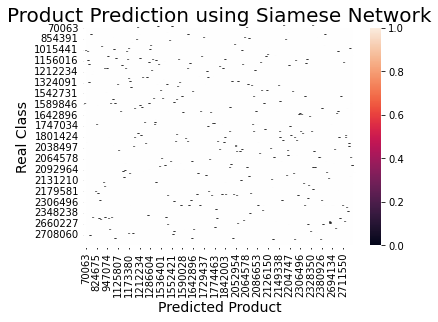

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.heatmap(df_confusion, annot=True)

plt.title('Product Prediction using Siamese Network', fontsize=20)

plt.xlabel('Predicted Product', fontsize=14)

plt.ylabel('Real Class', fontsize=14)

plt.show()

In [ ]:
fp_tp_dict = dict()
confusion_matrix = dict()
for i in mid_categ_list:
    t_count = 0
    f_count = 0
    fp_tp_dict[i] = {'T':t_count, 'F':f_count}
    
    confusion_column = {i :[j for j in mid_categ_list]}
for i, row in df_photoReview_002_apn_sim_matrix.iloc[0:].iterrows():
    min_index = np.argsort(df_photoReview_002_apn_sim_matrix.iloc[i, 10:])[1]
#     print(df_photoReview_002_apn_sim_matrix.loc[min_index]["mid_category"])
#     print(df_photoReview_002_apn_sim_matrix.iloc[i]["mid_category"])
    if df_photoReview_002_apn_sim_matrix.loc[min_index]["mid_category"] == df_photoReview_002_apn_sim_matrix.iloc[i]["mid_category"]:
        fp_tp_dict[df_photoReview_002_apn_sim_matrix.iloc[i]["mid_category"]]['T'] += 1
        
    else: 
        fp_tp_dict[df_photoReview_002_apn_sim_matrix.iloc[i]["mid_category"]]['F'] += 1

,filename,width,height,xmin,ymin,xmax,ymax,goods_id,mid_category,goods_image,...,distance_/content/drive/Othercomputers/내 노트북/12sw_project.v4i.tensorflow/train/1886950_0_gallery_60c4db34d6a73_jpg.rf.02412814c2859dcd265abdc02253805d.jpg,distance_/content/drive/Othercomputers/내 노트북/12sw_project.v4i.tensorflow/train/2086653_0_gallery_62345888dc0dc_jpg.rf.605d5833006597c62385edf30f82d9f7.jpg,distance_/content/drive/Othercomputers/내 노트북/12sw_project.v4i.tensorflow/train/2086653_0_gallery_630cd1178dabc_jpg.rf.e3fd3b9698875329092871551b73e4ab.jpg,distance_/content/drive/Othercomputers/내 노트북/12sw_project.v4i.tensorflow/train/2122566_0_gallery_620f9b230cce4_jpg.rf.d1717f819e67847d7f5cde4ed1c208bb.jpg,distance_/content/drive/Othercomputers/내 노트북/12sw_project.v4i.tensorflow/train/2122566_0_gallery_6316f1600ad9e_jpg.rf.224b174654773eb4f98f60ba03a7f950.jpg,distance_/content/drive/Othercomputers/내 노트북/12sw_project.v4i.tensorflow/train/2122566_0_gallery_624edccab0471_jpg.rf.b9a493c5adac519226c42cf054144357.jpg,distance_/content/drive/Othercomputers/내 노트북/12sw_project.v4i.tensorflow/train/2122566_0_gallery_625ff9c56c7b4_jpg.rf.7d29f515a9412da00eb68da67f4039b5.jpg,distance_/content/drive/Othercomputers/내 노트북/12sw_project.v4i.tensorflow/train/2122566_0_gallery_620f9ac6e3190_jpg.rf.0f6050783bd8032610caecca31d6674a.jpg,distance_/content/drive/Othercomputers/내 노트북/12sw_project.v4i.tensorflow/train/2122566_0_gallery_62af3eee9692a_jpg.rf.08f58629363a3fff35470c6c213734bf.jpg,distance_/content/drive/Othercomputers/내 노트북/12sw_project.v4i.tensorflow/train/2122566_0_gallery_625ff9c626d39_jpg.rf.0e6bd8f9d103e35dca0170e8f42cfed5.jpg
0,324416_0_gallery_60db0f3fda63b_jpg.rf.c122b1e0...,268,387,0,0,268,387,324416,001001,https://image.msscdn.net/images/goods_img/2016...,...,0.8209603,0.9290541,0.54703856,0.9376637,0.88988256,0.9144054,0.58323246,0.625577,1.2236446,1.5133655
1,324416_0_gallery_5f853b8b0c6cf_jpg.rf.2b9accc0...,299,219,0,0,299,219,324416,001001,https://image.msscdn.net/images/goods_img/2016...,...,1.2305309,0.3904549,0.96406,0.5526585,0.52677226,0.8197176,0.9162015,0.9945441,0.72917306,1.0744423
2,324416_0_gallery_5ea26b7970d44_jpg.rf.ec7dcbe5...,513,398,0,0,513,398,324416,001001,https://image.msscdn.net/images/goods_img/2016...,...,0.731051,1.0198026,0.44941685,1.0187114,0.9947051,1.0200989,0.7284517,0.6408458,1.404703,1.6803558
3,324416_0_gallery_60e300731d5a3_jpg.rf.78c96a5d...,336,353,0,0,336,353,324416,001001,https://image.msscdn.net/images/goods_img/2016...,...,1.4692386,0.67805594,1.1478335,0.7746029,0.75983757,0.92624134,1.0514166,1.148074,0.59072566,0.9950843
4,324416_0_gallery_5ebe49650f317_jpg.rf.6521b54e...,488,608,0,0,488,608,324416,001001,https://image.msscdn.net/images/goods_img/2016...,...,0.91926277,0.9940562,0.60557234,1.0683688,1.052838,1.130725,0.49393377,0.84449905,1.3357196,1.4083827
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259,2122566_0_gallery_624edccab0471_jpg.rf.b9a493c...,265,320,0,1,265,320,2122566,001001,https://image.msscdn.net/images/goods_img/2021...,...,1.0217116,0.6937356,0.9379304,0.57909703,0.52012134,0.0,1.0948699,0.8279769,0.9866054,1.5993536
260,2122566_0_gallery_625ff9c56c7b4_jpg.rf.7d29f51...,161,255,0,0,161,255,2122566,001001,https://image.msscdn.net/images/goods_img/2021...,...,0.969857,0.9537809,0.66606843,1.0382301,0.9766171,1.0948699,0.0,0.82978654,1.1878401,1.3277819
261,2122566_0_gallery_620f9ac6e3190_jpg.rf.0f60507...,176,143,0,0,176,143,2122566,001001,https://image.msscdn.net/images/goods_img/2021...,...,0.6504293,0.86287105,0.57612884,0.86997,0.82314014,0.8279769,0.82978654,0.0,1.2670008,1.7356935
262,2122566_0_gallery_62af3eee9692a_jpg.rf.08f5862...,300,339,0,0,300,339,2122566,001001,https://image.msscdn.net/images/goods_img/2021...,...,1.5961927,0.7585835,1.3128743,0.8407239,0.82034993,0.9866054,1.1878401,1.2670008,0.0,1.0649102
